### 一、文本向量化概述
文本向量化时将文本表示成一系列能够表达文本语义的机读向量。    
文本向量化按照向量化的粒度可以将其分为以字单位、以词为单位和以句子为单位向量表达，根据不同的情景选择不同的向量表达方式和处理方式。    
- 向量化表示主要分为 “离散表示” 和 “分布式表示”
- 1.离散表示
    - one-hot编码
    - 词袋模型(BOW)
    - tf-idf
- 2.分布式表示
    - word2vec
    - doc2vec

### 二、文本向量化方法
#### 1.离散表示
文本离散表示的特点时忽略文本信息中的语序信息和语境信息，仅将其反映为若干维度的独立概念。这类模型由于本身原因    
存在无法解决的问题，如主语和宾语的顺序问题，会导致无法理解诸如“我为你鼓掌”和“你为我鼓掌”两个语句之间的区别。    
- 独热编码时离散表示，是一种基于规则和统计的向量化方式，常用的方法有词集模型和词袋模型，将所有文本中的词形成一个字典，然后根据字典统计出现频数。
    - 1.词集模型用独热表示，只要单个文本中单词出现在字典中，就将其置为1，不管出现多少次
    - 2.BOW模型只要文本中一个词出现在字典中，就将向量值加1，出现多少次就加多少次。

##### （1）one-hot
one-hot表示的缺点：
- 1.维数过高：随着语料的增加，维数会越来越大，导致维数灾难。
- 2.矩阵稀疏：one-hot表示的每一个词向量只有1维是有数值的，其他维度上的数值都为0.
- 3.不能保留语义：one-hot表示的结果不能保留词语在句子中的位置信息。

例：
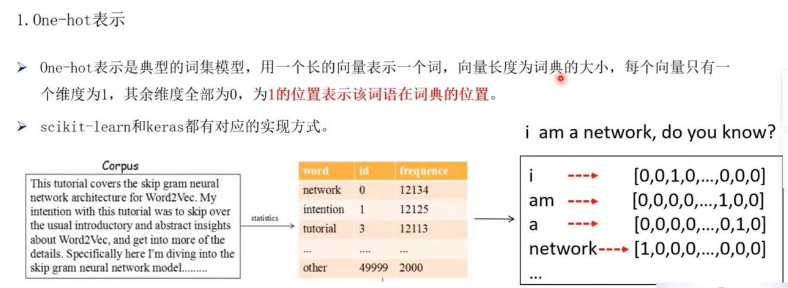

In [ ]:
# 方法1：手编：one_hot编码
import pandas as pd
import jieba
import re
import numpy as np

# 1.语料获取
data=pd.read_excel('.\data\\news.xls')
# 2.语料预处理
data['title']=data['title'].apply(lambda x:re.sub('[●★→\s\n\t]', '', x))
data['title'] = data['title'].apply(lambda x: re.sub('[0-9a-zA-Z]|<a.+</a>', '', x))
# 3.分词、去除停用词
cuts=data['title'].apply(jieba.lcut)

# 去除停用词
with open('.\data\\stoplist.txt','r',encoding='utf-8')as f:
    stop=[i.strip() for i in f.readlines()]
# 对整列数据进行去停用词
cuts = cuts.apply(lambda x: [i for i in x if i not in stop] )

# ------- 从这开始-------------
# 4.文本向量化
# 构建字典
token_index={}
for sample in cuts:
    for word in sample:
        if word not in token_index: # 如果该词么有被统计，加到字典中
            token_index[word]=len(token_index)
print(token_index)

# 构建变量存放结果,8*8*39 (8表示cuts有8行，8表示这8行中最长的一行为几，39表示字典的长度）
max_length=max(cuts.apply(len))# 计算cuts8行中最长的一行为多少
results=np.zeros((len(cuts),max_length,len(token_index.keys())))#构造一个向量为8，8，39
for i,sample in enumerate(cuts):
    for j,word in enumerate(sample):
        index=token_index.get(word)  # 获取某个词的位置序号
        results[i,j,index]=1

# 5.做分类建模
from keras.models import Sequential
from keras.layers import Dense,LSTM
model=Sequential()
model.add(LSTM(32,input_shape=(results.shape[1:])))
model.add(Dense(32))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(results,data['lable'],epochs=10)

end=np.round(model.predict(results))
print(end)


In [ ]:


# -------从这开始------
# 4.文本向量化
from keras.preprocessing.text import Tokenizer

tk=Tokenizer(num_words=50) # 只考虑最多50个常见词
# 将文本转为序列
tk.fit_on_texts(cuts)

# 统计词出现的次数
print('词出现的次数：',tk.word_counts)

# 词的位置（字典），将文本数据中的词映射到它们对应的整数编码
print('词的位置（字典）：',tk.word_index)

# 将词转换为对应的整数编码
sequences=tk.texts_to_sequences(cuts)
print('文本转为序列：',sequences)

# 将文本数据转为二进制句子的形式
result=tk.texts_to_matrix(cuts,mode='binary')
print('文本转为二进制矩阵；',result)


# 5.构建模型（贝叶斯分类）
from sklearn.naive_bayes import MultinomialNB
ndmodel=MultinomialNB()
ndmodel.fit(result,data['lable'])
end=ndmodel.predict(result)
print(end)

##### （2）词袋（Bag of Words:BOW)模型：
BOW模型就是用一个向量表示一句话或一个文档。    
BOW模型忽略文档的词语顺序、语法、句法等要素，将文档看作是若干个词汇的集合，文档中每个词都是独立的。    
BOW模型每个维度上的数值代表ID对应的词在句子里出现的频次。    
sklearn中的CountVectorizer()方法可以实现词频计数。    

In [ ]:
# -----从这开始------
# 4.文本向量化
from sklearn.feature_extraction.text import CountVectorizer

# 创建一个 CountVectorizer 对象
cv = CountVectorizer(
    # stop_words=stop,# 是否使用停用词
    lowercase=False,  # 是否转换为小写，默认为 True
    max_df=100,       # 词频的最大值，超过这个值的词将被忽略，默认为 1.0（不忽略任何词）
    min_df=1,        # 词频的最小值，低于这个值的词将被忽略，默认为 1（至少出现一次）
    max_features=100 # 最大特征数，只考虑词频最高的前几个特征词，默认为 None（考虑所有特征）
)
# 先把分词结果的列表转为字符串，[我，去，上学]-->'我 去 上学'
inputs=cuts.apply(lambda x:' '.join(x))

# 将文本数据转换为词频矩阵
words_counts = cv.fit_transform(inputs)
print(words_counts)

# 将词频矩阵转换为数组形式
words_array = words_counts.toarray()
print(words_array.shape)

# 建模
from sklearn.naive_bayes import MultinomialNB
nbmodel=MultinomialNB()
nbmodel.fit(words_array,data['lable'])
end=nbmodel.predict(words_array)
print(end)

##### （3）TF-IDF表示
有一篇很长的文章，要提取它的关键词，请问这样才能正确做到？    
一个容易想到的思路，就是找到出现次数最多的词。如果某个词神重要，它应该在这篇文章中多次出现。于是，我们进行“词频”（TF)统计    
TF-IDF表示是用一个向量表示一句话或一个文档，它的表示过程如下：
- 1.首先TF-IDF是在BOW的基础上对词出现的频次赋予TF-IDF权值。
- 2.其次对BOW模型进行修正，进而表示该词在文档集合中的重要程度
- TF-IDF概念理解：
    - 1.需要一个重要性调整系数，衡量一个词是不是常见词。如果某个词比较少见，但是它在这篇文章中多次出现，那么它很肯就反映了这篇文章的特性，正是我们所需要的关键词。
    - 2.用统计学语言表达，就是在词频的基础上，要对每个词分配一个“重要性”权重。这个权重叫做“逆文档频率”(IDF），它的大小与一个词的常见程度成反比。
    - 3.词出现的次数统计为“词频”（TF）

- TF-IDF计算：
    - 第一步：计算词频       某个词在文章中出现的次数/文章的总词数
    - 第二步：计算逆文档频率  log(语料库的文档总数/包含该词的文档数+1）
    - 第三步：TF-IDF=词频（TF）*逆文档频率（IDF）

- TF-IDF算法优缺点：
    - 1.TF-IDF算法的优点是简单快速，结果比较符合实际情况
    - 2.缺点是，单纯以”词频“衡量一个词的重要性，不够全面，有时重要的词可能出现的次数并不多。
    - 3.而且，这种算法无法体现词的位置信息，出现位置靠前的词与出现靠后的词，都被视为重要性相同，这是步正确大的。不能够考虑上下文的语境含义。

In [ ]:
# ----从这开始----
# 4.文本向量化
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer(
    # stop_words=stop, # 指定停用词
    max_features=100, # 最大特征个数
    max_df=100, # 词出现的最大次数
    min_df=1,   # 词出现的最小次数
)
# 先把分词结果的列表转为字符串，[我，去，上学]-->'我 去 上学'
inputs=cuts.apply(lambda x:' '.join(x))

# 将文本数据转成词频矩阵
words_tf=tf.fit_transform(inputs) # 输入字符串
print(words_tf)

# 将词频矩阵以数组表示出来
tfidf=words_tf.toarray()


# 5.建模
from sklearn.naive_bayes import MultinomialNB
nbmodel=MultinomialNB()
nbmodel.fit(tfidf,data['lable'])
end=nbmodel.predict(tfidf)
print(end)

#### 2.分布式表示

##### （1）Word2Vec模型
        随着深度学习技术的广泛应用，基于神经网络的文本向量化已经成为NLP领域的研究热点，尤其是以词为单位的向量化。
        Word2Vec是目前以词为单位中最典型的生成词向量的工具，其特点是将所有的词向量化，这样词与词之间即可度量它们之间的关系、挖掘词之间的联系。也有一部分研究将句子作为文本处理的基本单元，于是就产生了Doc2Vec和Str2Vec等技术。

        分布式表示将每个词根据上下文从高维空间映射到一个低纬度、稠密的向量上。分布式表示的思想是词的语义是通过上下文信息确定的，即相同语境出现的词，其语义也相近。
        分布式表示与one-hot表示对比，在形式上，one-hot表示的词向量是一种稀疏词向量，其长度就是字典长度，而分布式表示是一种固定长度的稠密词向量。

        Word2Vec模型是简单化的神经网络模型。Word2Vec可以在百万数量级的词典和上亿的数据集上进行高效地训练；该工具得到的训练结果可以很好地度量词与词之间的相似性。
        模型特点是，当模型训练好后，并不会使用训练好的模型处理新的任务，真正需要的是模型通过训练数据所学得得参数，如隐藏层得权值矩阵。

        Word2Vec模型获取一段文本的向量，是先对文本分词，提取文本的关键词，用Word2Vec获取这些关键词的词向量，然而，这种方法只保留了句子或文本中词的信息，却丢失了文本中的主题信息。为此，有研究者在Word2vec的基础上提出了文本向量化Doc2Vec模型

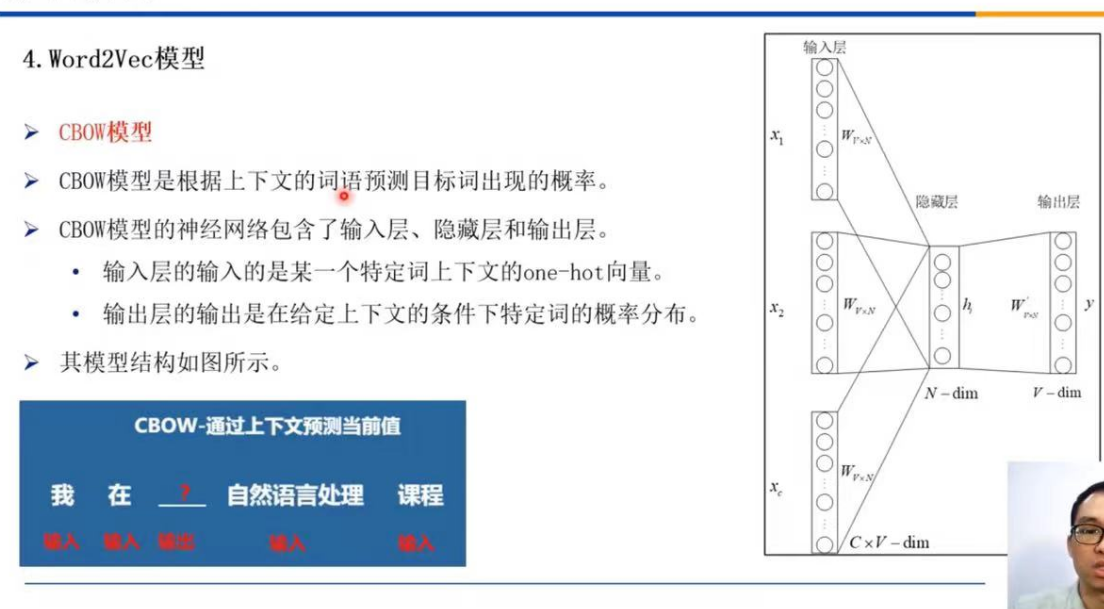
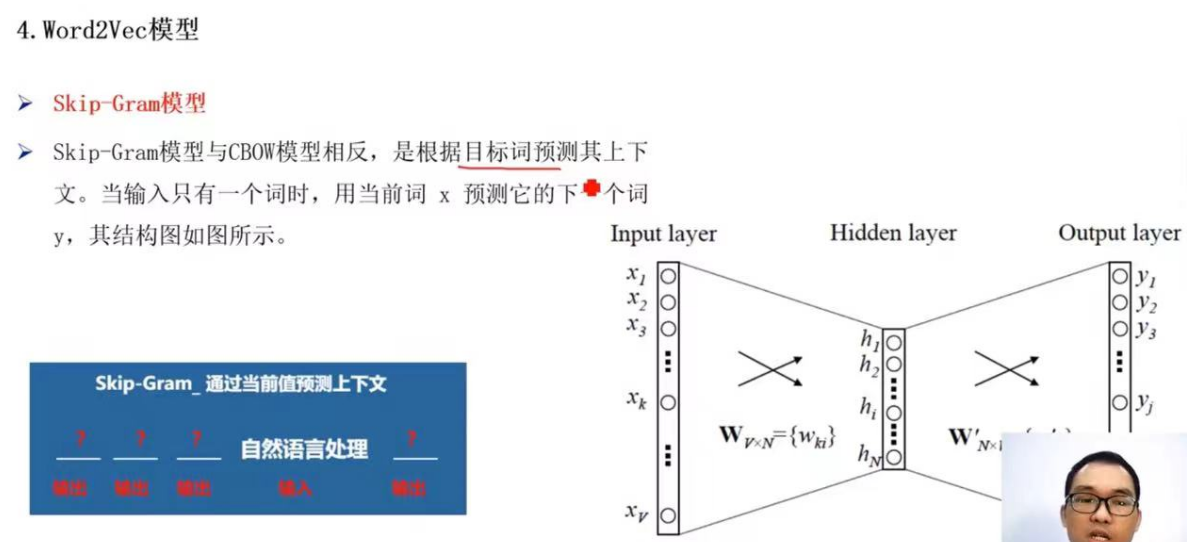

In [ ]:
# 4.文本向量化
import gensim
from gensim.models.word2vec import Word2Vec
# 训练词向量
wd=Word2Vec(
    sentences=cuts,# 待处理文本
    sg=0, # 对应cbow的算法
    vector_size=10, # 输出的每个词的词向量的长度
    max_vocab_size=50, # 词典的最大数量
    window=2, # 窗口大小
    min_count=1, # 词最少出现1次
    epochs=100, # 训练次数
)

# 结果
wd.wv.vector_size  # 向量长度
wd.wv.key_to_index # 每个词对应的id序号
wd.wv.vectors      # 每个词对应的词向量，模型的权值
wd.wv.get_vector('北华') # 获取词的向量
wd.wv.save_word2vec_format('./output.txt',binary=False)
wd.wv.similarity('司机','师傅') # 比较两个词的相似性
wd.wv.similar_by_word('交通',topn=3) # 找出与”交通“相关性最强的前3个词


# 获取每个词的词向量
def embading_sentence(sentence,model):
    all_vector=[] # 保存所有结果
    for i in sentence: # 循环每一个文本，得到列表
        Embading_matrix = np.zeros(wd.wv.vectors.shape)  # 全0矩阵，词不在字典中，默认为0
        for word in i: # 循环列表，获取列表中的每个词
            if word in wd.wv.key_to_index.keys():
                Embading_matrix[wd.wv.key_to_index.get(word)]=wd.wv.get_vector(word)
        all_vector.append(Embading_matrix)
    return np.array(all_vector)

# 对所有文本执行词向量转化
w2v=embading_sentence(cuts, wd)
print(w2v.shape)


# 5.做分类建模
from keras.models import Sequential
from keras.layers import Dense,LSTM
model=Sequential()
model.add(LSTM(32,input_shape=(w2v.shape[1:])))
model.add(Dense(32))
model.add(Dense(1,activation='sigmoid'))
# 模型编译
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(w2v,data['lable'],epochs=10)

end=np.round(model.predict(w2v))
print(end)


##### （2）Doc2Vec模型：
        Doc2vec方法是一种无监督算法，能从变长的文本（例如：句子、段落或文档）中学习得到固定长度的特征表示。
        Doc2Vec也可以叫做Paragraph Vector/Sentence Embeddings,它可以获得句子、段落和文档的向量表达，是Word2Vec的拓展，其具有一些优点，比如不用固定句子长度，接受不同长度的句子做训练样本。
        Doc2vec算法用于预测一个向量来表示不同的文档，该模型的结构潜在克服了词袋模型的缺点。

        Doc2Vec模型与Word2Vec模型类似，只是在Word2Vec模型输入层添加了一个词向量同维度的段落向量，可以将这个段落向量看作是另一个词向量。
        Doc2Vec存在如下两种模型：
            1.分布式记忆模型(DM)，对应Word2Vec模型里的CBOW,可以根据上下文词向量和段落向量预测目标的概率分布。
            2.分布式词袋模型（DBOW）：对应Word2Vec模型中的Skip-gram模型，只输入段落向量，预测从段落中随机抽取的词组概率分布。
        总而言之，Doc2Vec是Word2Vec的升级，Doc2Vec不仅提取文本的语义信息，还提取文本的语序信息。

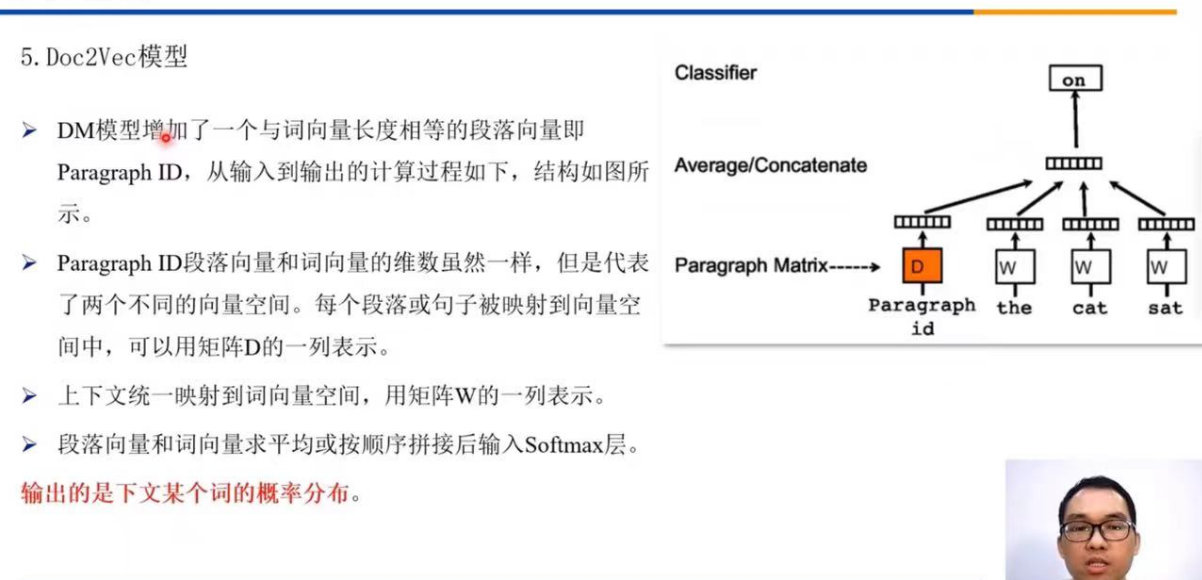
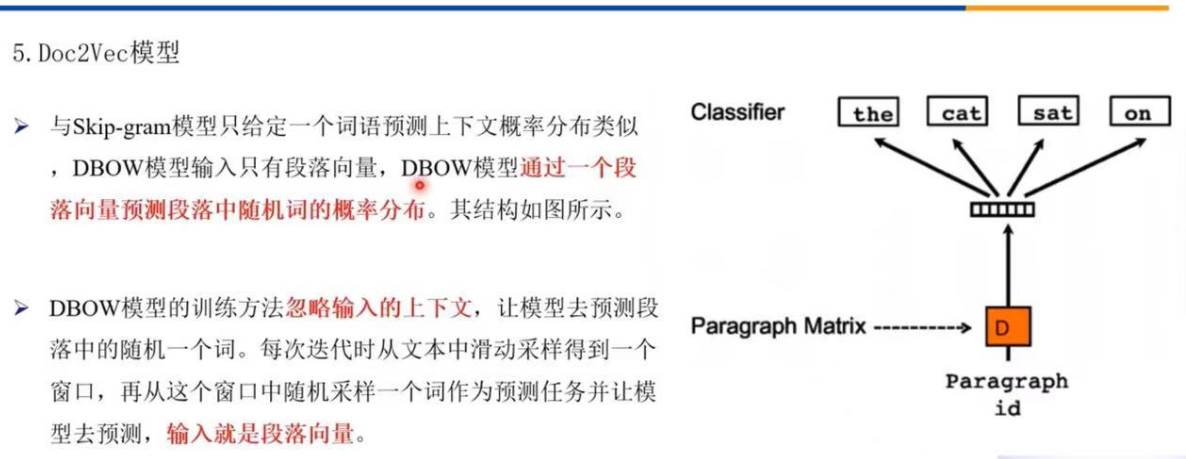

In [ ]:
# 4.文本向量
from gensim.models.doc2vec import Doc2Vec,TaggedDocument

# 先构建文档列表对象，可以不分词
document=[TaggedDocument(doc,[i]) for i,doc in enumerate(cuts)]

# 训练模型
d2vmodel=Doc2Vec(
    documents=document, # 输入文档列表对象
    vector_size=10, # 词向量的长度
    max_vocab_size=50, # 词典的最大数量
    min_count=1, # 词最少出现的次数
    epochs=100, # 训练次数
    dm=0,#使用DM模型
)

# 模型结果
d2vmodel.wv.key_to_index  # 字典，每个词对应的id序号
d2vmodel.wv.vectors       # 每个词对应的词向量
d2vmodel.wv.key_to_index.get('广播') # 获取广播中的id序号
d2vmodel.wv.get_vector('广播')       # 广播这个词的词向量
d2vmodel.wv.similarity('路口','交通堵塞') # 路口与交通堵塞之间的相似性
d2vmodel.wv.similar_by_word('交通',topn=3) # 与交通相似性最强的三个词

# 把句子变成向量
# 获取每个词的词向量
def embading_sentence(sentence,model):
    all_vector=[] # 保存所有结果
    for i in sentence: # 循环每一个文本，得到列表
        Embading_matrix = np.zeros(model.wv.vectors.shape)  # 全0矩阵，词不在字典中，默认为0
        for word in i: # 循环列表，获取列表中的每个词
            if word in model.wv.key_to_index.keys():
                Embading_matrix[model.wv.key_to_index.get(word)]=model.wv.get_vector(word)
        all_vector.append(Embading_matrix)
    return np.array(all_vector)

# 对所有文本执行词向量转化
d2v=embading_sentence(cuts, d2vmodel)
print(d2v.shape)


# 5.做分类建模
from keras.models import Sequential
from keras.layers import Dense,LSTM
model=Sequential()
model.add(LSTM(32,input_shape=(d2v.shape[1:])))
model.add(Dense(32))
model.add(Dense(1,activation='sigmoid'))
# 模型编译
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(d2v,data['lable'],epochs=10)

end=np.round(model.predict(d2v))
print(end)